In [507]:
import pandas as pd
import numpy as np

In [508]:
companies_selected = pd.read_excel("Companies.xlsx")

In [509]:
companies_selected.shape

(79, 5)

In [510]:
companies_selected.head()

,Company Name,Industry,Beta Value,Grade,TSR
0,NextEra Energy (NEE),Utilities,0.49,B,53.47
1,Duke Energy (DUK),Utilities,0.38,C,57.51
2,Atmos Energy (ATO),Utilities,0.50,B,54.13
3,Avangrid (AGR),Utilities,0.34,A,-8.57
4,Otter Tail (OTTR),Utilities,0.69,A,87.72


In [511]:
# since TSR is in % we will grade wight in % as well
grade_weight = {"A": 90, "B": 80, "C": 70, "D": 60, "E": 50, "F": 40}
companies_selected["GradeWeight"] = companies_selected["Grade"].map(grade_weight)

In [512]:
def calculate_grade_score(data, x):
    return (1 - x) * data["TSR"] + x * data["GradeWeight"]

In [513]:
def monte_carlo_simulation(
    data, max_industry_allocation=0.16, max_stock_allocation=0.045, target_beta=1.0
):
    best_portfolio = None
    best_portfolio_beta = float("inf")
    best_run = None

    for iteration in range(
        65000, 80000
    ):  # We want to keep the grade wight at a minumum of 0.65 of the total caluclation
        weight_factor = iteration / 100000  # Fraction for Grade Score calculation

        # Normalize TSR:
        data["Industry TSR total"] = data.groupby("Industry")["TSR"].transform("sum")
        data["Weighted TSR"] = data["TSR"] / data["Industry TSR total"]

        # Calculate Grade Score:
        data["Grade Score"] = data.apply(
            calculate_grade_score, axis=1, args=(weight_factor,)
        )

        # Calculate Weight:
        data["Weight"] = data["Grade Score"] / data["Grade Score"].sum()

        # Apply industry-level restrictions:
        data["Industry Allocation"] = data.groupby("Industry")["Weight"].transform(
            "sum"
        )
        data["Allocation_by_restriction"] = np.where(
            data["Industry Allocation"] > max_industry_allocation,
            max_industry_allocation,
            data["Industry Allocation"],
        )

        # Normalize Weights based on restrictions:
        data["Normalised Weight"] = np.where(
            data["Allocation_by_restriction"] == max_industry_allocation,
            (data["Weight"] / data["Industry Allocation"]) * max_industry_allocation,
            data["Weight"],
        )

        # Calculate Portfolio Beta:
        portfolio_beta = (data["Beta Value"] * data["Normalised Weight"]).sum()

        # Check if this portfolio is better:
        if portfolio_beta < best_portfolio_beta:
            test = weight_factor
            best_portfolio_beta = portfolio_beta
            best_run = iteration
            best_portfolio = data.copy()
            print(best_run, best_portfolio_beta)

    return test, best_run, best_portfolio_beta, best_portfolio

In [514]:
test, run_no, final_beta, ideal_portfolio = monte_carlo_simulation(companies_selected)
print(f"best run: {run_no} final_beta: {final_beta} ")
print(ideal_portfolio)

65000 0.8796795000604941
best run: 65000 final_beta: 0.8796795000604941 
                                Company Name          Industry  Beta Value  \
0                       NextEra Energy (NEE)         Utilities        0.49   
1                          Duke Energy (DUK)         Utilities        0.38   
2                         Atmos Energy (ATO)         Utilities        0.50   
3                             Avangrid (AGR)         Utilities        0.34   
4                          Otter Tail (OTTR)         Utilities        0.69   
..                                       ...               ...         ...   
74  COSTCO WHOLESALE CORPORATION (XNAS:COST)  Consumer Staples        0.79   
75      DOLLAR GENERAL CORPORATION (XNYS:DG)  Consumer Staples        0.45   
76       COLGATE-PALMOLIVE COMPANY (XNYS:CL)  Consumer Staples        0.41   
77            THE HERSHEY COMPANY (XNYS:HSY)  Consumer Staples        0.37   
78                    UNILEVER PLC (XBUE:UL)  Consumer Staples       

In [515]:
ideal_portfolio

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight
0,NextEra Energy (NEE),Utilities,0.49,B,53.47,80,358.64,0.149091,70.7145,0.009452,0.087150,0.087150,0.009452
1,Duke Energy (DUK),Utilities,0.38,C,57.51,70,358.64,0.160356,65.6285,0.008772,0.087150,0.087150,0.008772
2,Atmos Energy (ATO),Utilities,0.50,B,54.13,80,358.64,0.150931,70.9455,0.009483,0.087150,0.087150,0.009483
3,Avangrid (AGR),Utilities,0.34,A,-8.57,90,358.64,-0.023896,55.5005,0.007418,0.087150,0.087150,0.007418
4,Otter Tail (OTTR),Utilities,0.69,A,87.72,90,358.64,0.244591,89.2020,0.011923,0.087150,0.087150,0.011923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,COSTCO WHOLESALE CORPORATION (XNAS:COST),Consumer Staples,0.79,D,17.43,60,177.69,0.098092,45.1005,0.006028,0.077816,0.077816,0.006028
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,14.09,80,177.69,0.079295,56.9315,0.007609,0.077816,0.077816,0.007609
76,COLGATE-PALMOLIVE COMPANY (XNYS:CL),Consumer Staples,0.41,A,15.40,90,177.69,0.086668,63.8900,0.008540,0.077816,0.077816,0.008540
77,THE HERSHEY COMPANY (XNYS:HSY),Consumer Staples,0.37,B,12.95,80,177.69,0.072880,56.5325,0.007556,0.077816,0.077816,0.007556


In [516]:
ideal_portfolio["Normalised Weight"].sum()

0.871516904975013

In [517]:
ideal_portfolio["final_weight"] = (
    ideal_portfolio["Normalised Weight"] / ideal_portfolio["Normalised Weight"].sum()
) * 100

In [ ]:
a = ideal_portfolio

In [ ]:
# -------------------------------------------------------------- for capping stocks at 4.5%

ideal_portfolio["Capped_weight"] = np.minimum(ideal_portfolio["final_weight"], 4.5)

while True:
    industry_totals = ideal_portfolio.groupby("Industry")["final_weight"].transform(
        "sum"
    )
    capped_totals = ideal_portfolio.groupby("Industry")["Capped_weight"].transform(
        "sum"
    )
    excess_weight = industry_totals - capped_totals

    if (excess_weight <= 0).all():
        break

    # Identify eligible stocks (below cap) for redistribution
    eligible = ideal_portfolio["Capped_weight"] < 4.5
    eligible_totals = (
        ideal_portfolio[eligible].groupby("Industry")["Capped_weight"].transform("sum")
    )

    # Redistribute proportionally among eligible stocks
    redistribution = (
        ideal_portfolio["Capped_weight"] / eligible_totals
    ) * excess_weight
    redistribution = redistribution.fillna(
        0
    )  # Avoid NaN for industries with no eligible stocks
    ideal_portfolio.loc[eligible, "Capped_weight"] += redistribution[eligible]

    # Reapply the cap
    ideal_portfolio["Capped_weight"] = np.minimum(ideal_portfolio["Capped_weight"], 4.5)

ideal_portfolio

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight,final_weight,Capped_weight
0,NextEra Energy (NEE),Utilities,0.49,B,53.47,80,358.64,0.149091,70.7145,0.009452,0.087150,0.087150,0.009452,1.084513,1.084513
1,Duke Energy (DUK),Utilities,0.38,C,57.51,70,358.64,0.160356,65.6285,0.008772,0.087150,0.087150,0.008772,1.006512,1.006512
2,Atmos Energy (ATO),Utilities,0.50,B,54.13,80,358.64,0.150931,70.9455,0.009483,0.087150,0.087150,0.009483,1.088056,1.088056
3,Avangrid (AGR),Utilities,0.34,A,-8.57,90,358.64,-0.023896,55.5005,0.007418,0.087150,0.087150,0.007418,0.851184,0.851184
4,Otter Tail (OTTR),Utilities,0.69,A,87.72,90,358.64,0.244591,89.2020,0.011923,0.087150,0.087150,0.011923,1.368047,1.368047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,COSTCO WHOLESALE CORPORATION (XNAS:COST),Consumer Staples,0.79,D,17.43,60,177.69,0.098092,45.1005,0.006028,0.077816,0.077816,0.006028,0.691684,0.691684
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,14.09,80,177.69,0.079295,56.9315,0.007609,0.077816,0.077816,0.007609,0.873130,0.873130
76,COLGATE-PALMOLIVE COMPANY (XNYS:CL),Consumer Staples,0.41,A,15.40,90,177.69,0.086668,63.8900,0.008540,0.077816,0.077816,0.008540,0.979849,0.979849
77,THE HERSHEY COMPANY (XNYS:HSY),Consumer Staples,0.37,B,12.95,80,177.69,0.072880,56.5325,0.007556,0.077816,0.077816,0.007556,0.867011,0.867011


In [529]:
ideal_portfolio["Capped_weight"].max()

4.5

### VERIFY PORTFOLIO CONSTRATINTS -

In [532]:
round(ideal_portfolio["Capped_weight"].sum(), 2) == 100.00

True

In [538]:
ideal_portfolio.sort_values(by="Capped_weight", ascending=False)

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight,final_weight,Capped_weight
40,TSLA,Technology,2.12,A,1236.11,90,4829.52,0.255949,491.1385,0.065646,0.288483,0.160000,0.036409,4.177629,4.500000
44,NVDA,Technology,1.76,C,2694.86,70,4829.52,0.557997,988.7010,0.132150,0.288483,0.160000,0.073294,8.409901,4.500000
25,Eli Lilly and Company (LLY),Healthcare,0.42,C,675.16,70,1435.04,0.470482,281.8060,0.037666,0.136636,0.136636,0.037666,4.321918,4.321918
10,Interactive Brokers (IBKR),Finance,0.79,D,303.51,60,1525.19,0.198998,145.2285,0.019411,0.139116,0.139116,0.019411,2.227297,2.227297
11,LPL Financial (LPLA),Finance,0.85,C,276.95,70,1525.19,0.181584,142.4325,0.019038,0.139116,0.139116,0.019038,2.184416,2.184416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,COIN,Technology,3.34,B,-10.57,80,4829.52,-0.002189,48.3005,0.006456,0.288483,0.160000,0.003581,0.410845,0.666234
65,"Hitachi, Ltd. (OTCM:HTHIY)",Industruals,1.15,D,8.50,60,125.13,0.067929,41.9750,0.005610,0.069275,0.069275,0.005610,0.643750,0.643750
61,"UNITED PARCEL SERVICE, INC. (XNYS:UPS)",Industruals,0.98,D,6.04,60,125.13,0.048270,41.1140,0.005495,0.069275,0.069275,0.005495,0.630545,0.630545
47,SNOW,Technology,1.37,A,-47.52,90,4829.52,-0.009839,41.8680,0.005596,0.288483,0.160000,0.003104,0.356130,0.577507


In [536]:
a = ideal_portfolio.groupby("Industry")["final_weight"].sum()
a

Industry
Consumer Staples     8.928781
Energy              13.500278
Finance             15.962484
Healthcare          15.677953
Industruals          7.948840
Real Estate          9.623103
Technology          18.358795
Utilities            9.999767
Name: final_weight, dtype: float64

In [523]:
# ---------------------------------------------------------------------- EVERYTHING BELOW IS FOR TESTING OUT PORTFOLIO

In [541]:
final_port = ideal_portfolio[["Company Name", "Capped_weight"]]
ticker_map = pd.read_excel("ticker_map.xlsx")
mapping_dict = dict(zip(ticker_map["Company Name"], ticker_map["Ticker"]))
# final_port = final_port.copy()
final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)

C:\Users\asus\AppData\Local\Temp\ipykernel_25280\654386724.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)


In [542]:
final_port = final_port.set_index("Ticker")
final_port

,Company Name,Capped_weight
Ticker,,
NEE,NextEra Energy (NEE),1.084513
DUK,Duke Energy (DUK),1.006512
ATO,Atmos Energy (ATO),1.088056
AGR,Avangrid (AGR),0.851184
OTTR,Otter Tail (OTTR),1.368047
...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849


In [543]:
start_date = pd.to_datetime("today")

# Generate the previous 30 days, starting from today
dates = pd.date_range(
    start=start_date - pd.Timedelta(days=29), end=start_date, freq="D"
)

# Create a DataFrame with 30 empty columns (NaN values) for each of the previous 30 days
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

,Company Name,Capped_weight,2024-11-02,2024-11-03,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,...,2024-11-22,2024-11-23,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.084513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DUK,Duke Energy (DUK),1.006512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATO,Atmos Energy (ATO),1.088056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGR,Avangrid (AGR),0.851184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTTR,Otter Tail (OTTR),1.368047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [548]:
### USE THISS

import yfinance as yf
from datetime import datetime, timedelta


def get_returns(ticker, checkdate):
    # Calculate the start of the year for the given date
    try:
        start_of_year = datetime.today() - timedelta(days=30)

        # Fetch data using yfinance
        data = yf.download(ticker, start=start_of_year, end=checkdate, interval="1d")

        # Get the adjusted close price on the first day of the year
        start_price = data["Adj Close"].iloc[0]  # Price on the start of the year

        # Calculate the return as the percentage change from the start of the year
        current_price = data["Adj Close"].iloc[-1]  # Price on the current date

        pct_change = ((current_price / start_price) - 1) * 100  # Percentage change

        return pct_change

    except Exception as e:
        # Catch the specific error for failed downloads
        print(f"Failed to download data for {ticker}: {e}")
        return None


for indx in df_updated.index:
    for months in df_updated.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object

        # Update your DataFrame with the calculated return
        if indx == "PKST":
            break
        else:
            df_updated.at[indx, months] = get_returns(indx, month).values[0]

df_updated

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Company Name,Capped_weight,2024-11-02,2024-11-03,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,...,2024-11-22,2024-11-23,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.084513,NaN,0.0,0.0,1.318687,1.680676,-3.658697,-3.529406,-0.491270,...,0.012931,-1.745312,-1.745312,-1.745312,-0.917904,0.180995,2.192917,2.192917,2.388142,1.706528
DUK,Duke Energy (DUK),1.006512,NaN,0.0,0.0,-0.141998,1.242455,0.843090,-1.419949,0.488108,...,1.934683,1.792684,1.792684,1.792684,2.058928,3.869365,4.206601,4.206601,4.868368,4.868368
ATO,Atmos Energy (ATO),1.088056,NaN,0.0,0.0,-0.527454,-0.303467,0.346829,2.196538,4.183532,...,8.569365,8.417637,8.417637,8.417637,8.511560,8.619948,9.414739,9.414739,9.335270,9.335270
AGR,Avangrid (AGR),0.851184,NaN,0.0,0.0,-0.028093,0.280974,-0.028093,0.252880,0.871035,...,1.798256,1.376796,1.376796,1.376796,1.573480,1.629666,1.573480,1.573480,1.432982,1.432982
OTTR,Otter Tail (OTTR),1.368047,NaN,0.0,0.0,0.563456,4.430794,9.514663,5.634526,1.242158,...,3.188636,3.444747,3.444747,3.444747,4.930217,2.740437,3.572802,3.572802,3.265467,3.265467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684,NaN,0.0,0.0,0.998508,1.465843,2.500827,4.174123,7.578848,...,8.929572,9.882483,9.882483,9.882483,9.526851,10.736228,9.602078,9.602078,10.779543,10.779543
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130,NaN,0.0,0.0,0.293539,-0.232390,-5.320448,-4.513212,-5.883079,...,-9.589046,-8.353720,-8.353720,-8.353720,-6.323392,-8.708418,-6.727006,-6.727006,-5.491690,-5.491690
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849,NaN,0.0,0.0,-0.386245,-0.423029,-0.251366,-0.208446,1.256822,...,3.703018,3.794986,3.794986,3.794986,1.968001,2.599476,2.476852,2.476852,2.489116,2.489116


In [546]:
# data = yf.download("SPY", start="2023-01-01", end="2023-06-01", interval="1mo")
# # Get the adjusted close price on the first day of the year
# start_price = data["Adj Close"].iloc[0]  # Price on the start of the year

# # Calculate the return as the percentage change from the start of the year
# current_price = data["Adj Close"].iloc[-1]  # Price on the current date

# pct_change = ((current_price / start_price) - 1) * 100  # Percentage change

# pct_change.values[0]

ValueError: x and y must have same first dimension, but have shapes (30,) and (0, 32)

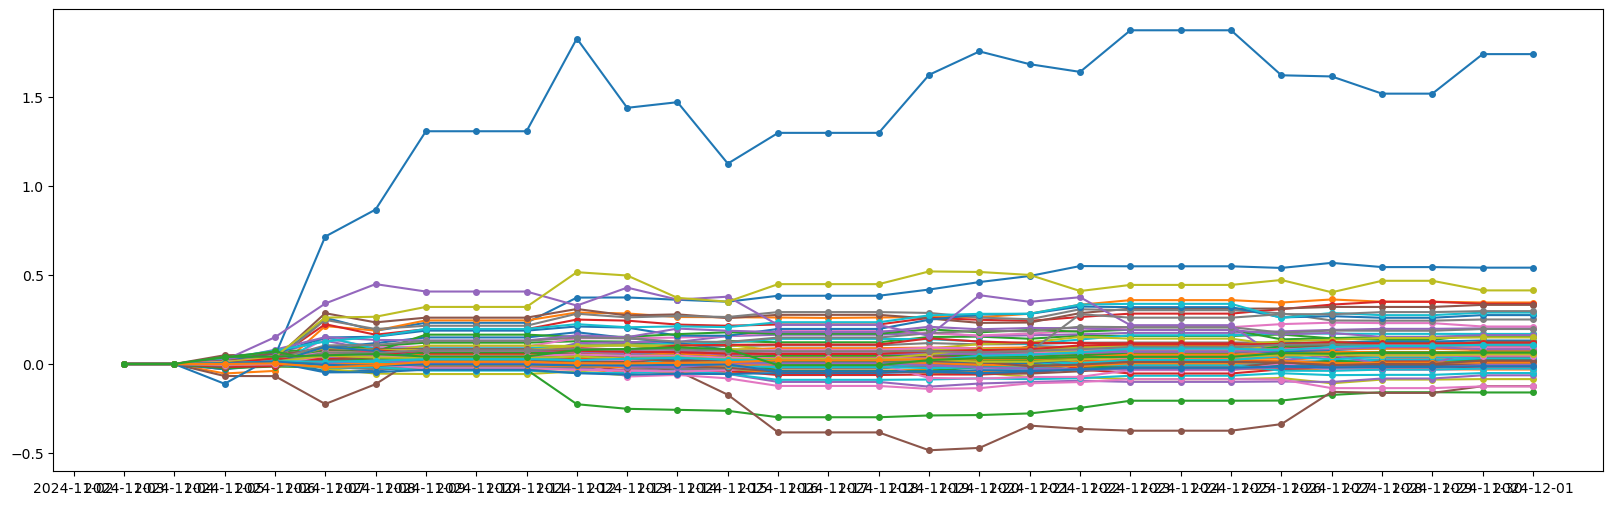

In [554]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
for ticker in df_updated.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_updated.columns[2:],
        df_updated.loc[ticker].values[2:],
        label=ticker,
        marker="o",
        markersize=4,
    )

plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (YTD)")
plt.xticks(rotation=45)
plt.title("YTD % Change for each stock in our portfolio (UNWEIGHTED)")
plt.show()

In [550]:
for col in df_updated.columns[2:]:
    df_updated[col] = df_updated[col] * (df_updated["Capped_weight"] / 100)
df_updated

,Company Name,Capped_weight,2024-11-02,2024-11-03,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,...,2024-11-22,2024-11-23,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.084513,NaN,0.0,0.0,0.014301,0.018227,-0.039679,-0.038277,-0.005328,...,0.000140,-0.018928,-0.018928,-0.018928,-0.009955,0.001963,0.023782,0.023782,0.025900,0.018508
DUK,Duke Energy (DUK),1.006512,NaN,0.0,0.0,-0.001429,0.012505,0.008486,-0.014292,0.004913,...,0.019473,0.018044,0.018044,0.018044,0.020723,0.038946,0.042340,0.042340,0.049001,0.049001
ATO,Atmos Energy (ATO),1.088056,NaN,0.0,0.0,-0.005739,-0.003302,0.003774,0.023900,0.045519,...,0.093239,0.091589,0.091589,0.091589,0.092611,0.093790,0.102438,0.102438,0.101573,0.101573
AGR,Avangrid (AGR),0.851184,NaN,0.0,0.0,-0.000239,0.002392,-0.000239,0.002152,0.007414,...,0.015306,0.011719,0.011719,0.011719,0.013393,0.013871,0.013393,0.013393,0.012197,0.012197
OTTR,Otter Tail (OTTR),1.368047,NaN,0.0,0.0,0.007708,0.060615,0.130165,0.077083,0.016993,...,0.043622,0.047126,0.047126,0.047126,0.067448,0.037490,0.048878,0.048878,0.044673,0.044673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),0.691684,NaN,0.0,0.0,0.006907,0.010139,0.017298,0.028872,0.052422,...,0.061764,0.068356,0.068356,0.068356,0.065896,0.074261,0.066416,0.066416,0.074560,0.074560
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.873130,NaN,0.0,0.0,0.002563,-0.002029,-0.046454,-0.039406,-0.051367,...,-0.083725,-0.072939,-0.072939,-0.072939,-0.055211,-0.076036,-0.058736,-0.058736,-0.047950,-0.047950
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),0.979849,NaN,0.0,0.0,-0.003785,-0.004145,-0.002463,-0.002042,0.012315,...,0.036284,0.037185,0.037185,0.037185,0.019283,0.025471,0.024269,0.024269,0.024390,0.024390


In [551]:
# Sum the values of each column (from the 3rd column onward)
column_sums = df_updated.iloc[:, 2:].sum(axis=0)

# Create a new DataFrame with the same columns
df_sums = pd.DataFrame(
    column_sums
).T  # Transpose to match the structure of the original DataFrame
df_sums.columns = df_updated.columns[
    2:
]  # Assign the column names from the 3rd column onward

# Add the two new index values: 'portfolio name' and 'SPY'
df_sums.index = ["portfolio"]
spy_values = ["NaN", "NaN", "NaN"]

# Iterate over the columns from the 3rd column onward
for months in df_updated.columns[3:]:
    if isinstance(months, str):
        month = datetime.strptime(months, "%Y-%m-%d")
    else:
        month = months  # Already a datetime object
    month = datetime.strptime(months, "%Y-%m-%d")
    spy_value = get_returns("SPY", month).values[0]
    spy_values.append(spy_value)

spy_values = pd.DataFrame([spy_values])
spy_values.columns = df_updated.columns
spy_values.index = ["SPY"]
df_sums = pd.concat([df_sums, spy_values])
df_sums

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,2024-11-02,2024-11-03,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,...,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,Company Name,Capped_weight
portfolio,0.0,0.0,0.0,-0.010516,1.337882,4.572421,4.732329,6.071844,6.071844,6.071844,...,7.609375,7.609375,7.426873,7.669585,7.720506,7.720506,8.225073,8.217681,NaN,NaN
SPY,NaN,0.0,0.0,-0.215393,0.991180,3.502382,4.302677,4.754488,4.754488,4.754488,...,4.285170,4.285170,4.638914,5.185284,4.866566,4.866566,5.518004,5.518004,NaN,NaN


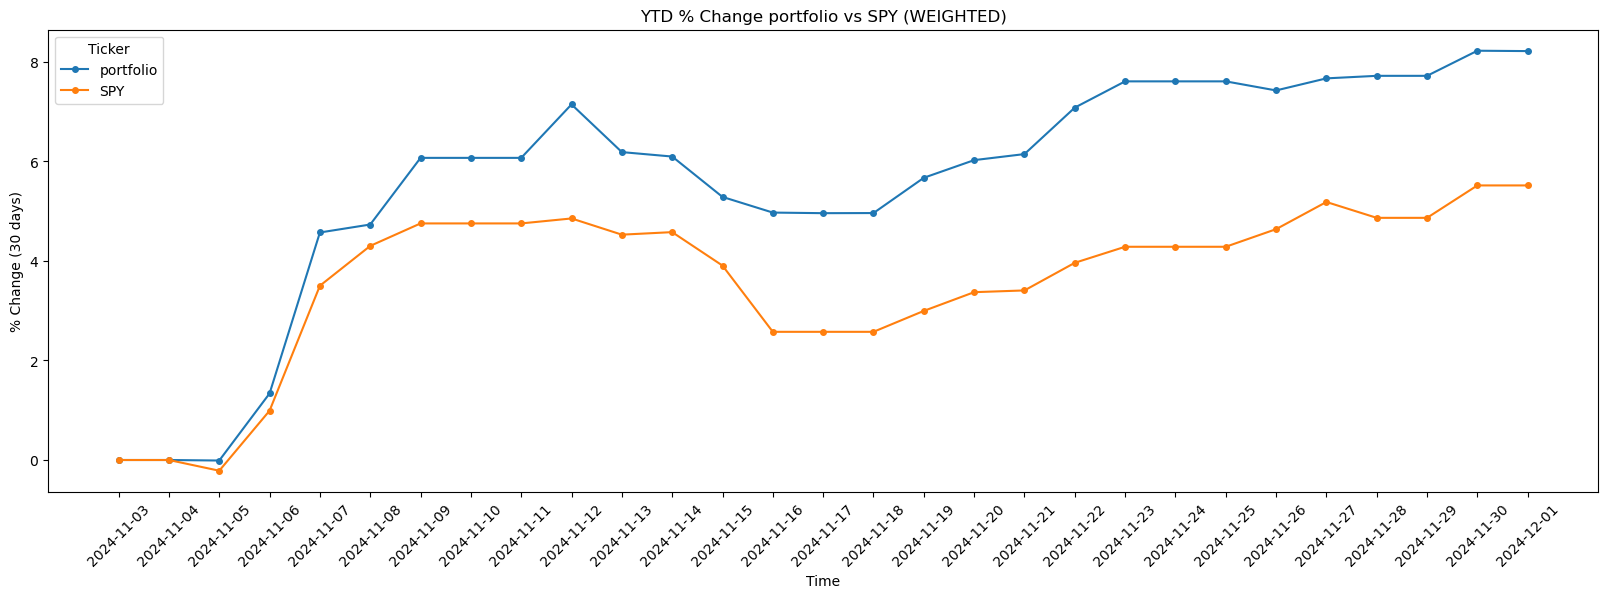

In [557]:
plt.figure(figsize=(20, 6))
for ticker in df_sums.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_sums.columns[1:-2],
        df_sums.loc[ticker].values[1:-2],
        label=ticker,
        marker="o",
        markersize=4,
    )

plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (30 days)")
plt.title("YTD % Change portfolio vs SPY (WEIGHTED)")
plt.xticks(rotation=45)
plt.show()